# Fake data from Bayesian networks

The package `fake_data_for_learning` features two main classes

* `BayesianNodeRV`, a discrete random (or conditional random) variable suited for creating Bayesian networks
* `FakeDataBayesianNetwork`, a Bayesian network consisting of instances of `BayesianNodeRV`s.


In [1]:
import warnings

import numpy as np
import pandas as pd
import sklearn

import matplotlib.pyplot as plt
from pandas.plotting import table

from fake_data_for_learning import BayesianNodeRV as BNRV
from fake_data_for_learning import FakeDataBayesianNetwork as FDBN
from fake_data_for_learning import SampleValue

warnings.filterwarnings("ignore", module="networkx")
%matplotlib inline

## Examples of Bayesian node random variables

Bayesian node random variables either true random variables with distribution defined by a probability table `pt`, or a conditional random variable defined by a conditional probability table.

### Example

For example, let $X0$ be a binary random variable with probability table $[0.8, 0.2]$ and values / outcomes $\{0,1\}$.

In [2]:
pt_X0 = np.array([0.8, 0.2])
rv0 = BNRV('X0', pt_X0)
print(rv0)

BayesianNodeRV(X0, parent_names=None)


In this case, $X0$ is a true random variable, and can be sampled without specifying parent values.

In [3]:
rv0.rvs(size=10)

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

Next assume that $X1$ is a conditional random variable on $X0$, with conditional probability function $P(X1 | X0)$. For implementation reasons, we depart from the usual convention of conditional probability tables (e.g. https://en.wikipedia.org/wiki/Conditional_probability_table) and, for $X1$ taking $n$ values, and $X0$ taking $m$ values (in the above example, $m=2$), the conditional probability table is a matrix of shape $(m,n)$, where the *rows* are the marginal probability distributions of $X2$ for different values of $X1$.

### Example

We give an example of $X1 | X0$, where $X0$ is as above and $X1 | X0$ is also binary.

In [4]:
# Let X0 be as above
pt_X1cX0 = np.array([
        [0.2, 0.8],
        [0.7, 0.3],
])

rv1c0 = BNRV('X1', pt_X1cX0, parent_names=['X0'])
print(rv1c0)

BayesianNodeRV(X1, parent_names=['X0'])


To sample from a conditional random variable, the marginal value must be provided. We do this using a helper class `SampleValue`, whose utility become apparent in the case of random variables that take on non-default values, e.g. `['female', 'male']`; see below.

In [5]:
parent_values={'X0': SampleValue(1)}
# Get probability table when X0=1
rv1c0.get_pt(parent_values)

array([0.7, 0.3])

In [6]:
rv1c0.rvs(size=10, parent_values={'X0': SampleValue(1)})

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

If the random variable take on non-default (i.e. non-natural number) values, then these values must be mapped to the default of values by a label encoder.

In [7]:
Gender = BNRV('Gender', np.array([0.55, 0.45]), values=['female', 'male'])
print(Gender)

BayesianNodeRV(Gender, parent_names=None)


In [8]:
Gender.label_encoder.transform(['female', 'male', 'male'])

array([0, 1, 1])

To sample from a conditional random variable $(Y1 \, |\, \textrm{gender})$, we need to pass in values of `Gender` with a label encoder, which maps the value (`male` or `female`) to the row of the conditional probability table `pt_X1cGender` to use for sampling. To pass sampled parent values, we use the class `SampleValue`.

In [9]:
pt_YcGender = np.array([
    [0.9, 0.1],
    [0.4, 0.6],
])
Y = BNRV('Y1', pt_YcGender, parent_names=['Gender'])
Y.rvs({'Gender': SampleValue('male', label_encoder=Gender.label_encoder)})

array([0])

Note that the scikit-learn label encoder sorts values (aka classes) into lexicographic order, which mean that the definition of the conditional probability tables must also respect this ordering. Entering non-default values not in lexicographic order throws a value error.

In [10]:
try:
    BNRV('gender', np.array([0.45, 0.55]), values=['male', 'female'])
except ValueError as err:
    print(err)

Values must be unique and in lexicographic order


## Examples of fake data Bayesian networks

Bayesian random variables with compatible parent names and (conditional) probability tables can be combined into a Bayesian network.

In [11]:
bn = FDBN(rv0, rv1c0)
print(bn)

FakeDataBayesianNetwork with node_names=['X0', 'X1'])


Part of class instantiation involves checking compatability of the nodes of the network, including the sizes of the respective probability tables.

In [12]:
bn.get_node('X1').cpt.shape == bn.get_expected_cpt_dims([1], len(rv0.values))

True

### Visualizing the Bayesian network

We use the visualization features of [NetworkX](https://networkx.github.io/) to visualize the Bayesian network.

In [13]:
bn.node_names

['X0', 'X1']

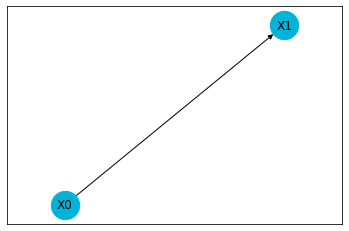

In [14]:
# Visualize the graph
bn.draw_graph()

### Sampling from the graph

To generate a random sample for $X$, we define the adjacency graph of $G$ and use this to first sample from the Eve-nodes (no parents), and then Eve's immediate descendents, and so on. 

In [15]:
# Sample
bn.rvs(size=5)

,X0,X1
0,0,1
1,0,0
2,1,1
3,0,0
4,0,1


## Example

$X = (X0, X1, X2)$, where $X$ admits the graph

G: X0 -> X2 <- X1

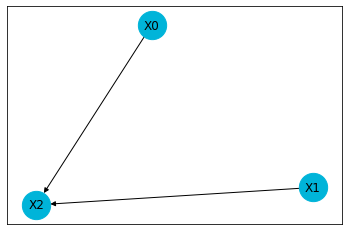

In [16]:
# X1
pt_X1 = np.array([0.5, 0.3, 0.2])
rv1 = BNRV('X1', pt_X1)

# X2 | X0, X1
pt_X2cX0X1 = np.array([
    [
        [0., 1.0],
        [0.2, 0.8],
        [0.1, 0.9]
    ],
    [
        [0.5, 0.5],
        [0.3, 0.7],
        [0.9, 0.1]
    ],

])

rv2c01 = BNRV('X2', pt_X2cX0X1, parent_names=['X0', 'X1'])

bn2c01 = FDBN(rv0, rv1, rv2c01)
bn2c01.draw_graph()

In [17]:
# Sample
bn2c01.rvs(size=5)

,X0,X1,X2
0,0,0,1
1,0,2,1
2,0,0,1
3,1,2,0
4,0,1,1


## Bayesian network with non-default (non-integer) outcome values

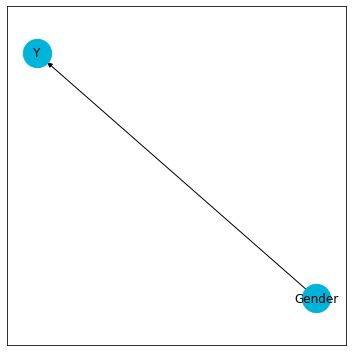

In [18]:
pt_YcGender = np.array([
    [0.9, 0.1],
    [0.4, 0.6],
])
Y = BNRV('Y', pt_YcGender, parent_names=['Gender'])
bn_nondef = FDBN(Gender, Y)

fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)

G = bn_nondef.get_graph()
bn_nondef.draw_graph()

plt.tight_layout()
plt.savefig("../docs/graphics/graph.png", format="PNG")


Sample

In [19]:
samples = bn_nondef.rvs(size=10)
samples

,Gender,Y
0,female,0
1,male,1
2,female,0
3,male,1
4,male,0
5,female,0
6,female,0
7,female,0
8,male,1
9,female,0


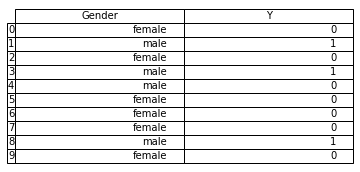

In [20]:
# For README
fig = plt.figure(figsize=(5, 2.5))
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False) 
ax.yaxis.set_visible(False)
table(ax, samples, loc='center')
plt.tight_layout()
plt.savefig('../docs/graphics/network_sample.png')